In [1]:
import os
import pickle
import gc

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
import pandas as pd

from openretina.hoefling_2024.configs import model_config, trainer_config
from openretina.hoefling_2024.data_io import natmov_dataloaders_v2
from openretina.hoefling_2024.models import SFB3d_core_SxF3d_readout
from openretina.hoefling_2024.nnfabrik_model_loading import load_ensemble_retina_model_from_directory
from openretina.neuron_data_io import make_final_responses
from openretina.training import standard_early_stop_trainer as trainer
from openretina.utils.h5_handling import load_h5_into_dict
from openretina.utils.misc import CustomPrettyPrinter
from openretina.optimization.objective import SingleNeuronObjective
from openretina.optimization.optimizer import optimize_stimulus
from openretina.optimization.regularizer import range_regularizer_fn, ChangeNormJointlyClipRangeSeparately

from rgc_natstim_model.constants.plot_settings import cmap_colors as rgc_colors


In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pp = CustomPrettyPrinter(indent=4, max_lines=40)

from functools import partial

import sys
# sys.path.append('/gpfs01/euler/User/lhoefling/GitHub/nnfabrik_euler')
sys.path.append('/gpfs01/euler/User/tzenkel/GitRepos/nnfabrik_euler')
DEVICE = "cuda"

# Datasets and neurons to analyse

In [3]:
# base_folder = '/gpfs01/euler/User/lhoefling/project_clean_up/'
base_folder = '/gpfs01/euler/data/SharedFiles/projects/Hoefling2024'

ensemble_hash = "9d574ab9fcb85e8251639080c8d402b7"
dataset_hash = "57ff42f31240ab511be30f98b4a07ffe"
method_hash = "d9d8fe9725fb8667fa71c7ab44889c37"
session_id_neuron_id_list = [
    ('3_ventral1_20201030', '20201030_1_3_65_s_5'), 
    ('3_ventral2_20201117', '20201117_2_3_24_s_5'), 
    ('2_ventral2_20201117', '20201117_2_2_96_s_5'), 
    ('3_ventral2_20201117', '20201117_2_3_82_s_5'), 
    ('4_ventral2_20201022', '20201022_2_4_12_s_5'), 
    ('1_ventral1_20201030', '20201030_1_1_90_s_5'), 
    ('2_ventral2_20201022', '20201022_2_2_87_s_5'), 
    ('3_ventral2_20201022', '20201022_2_3_57_s_5'), 
    ('4_ventral2_20201022', '20201022_2_4_13_s_5'), 
    ('2_ventral1_20201021', '20201021_1_2_18_s_5'), 
    ('3_ventral2_20201022', '20201022_2_3_45_s_5'),
]
session_id_neuron_pos_list = [(x[0], int(x[1].split("_")[3])) for x in session_id_neuron_id_list]

## plot settings

In [4]:
rc_dict = {
    'figure.dpi': 300,
    'figure.figsize': [2,2],
    'figure.frameon': False,
    'font.size': 8,
    'lines.markersize':1,
    'lines.markeredgewidth': .1,
    'legend.columnspacing': .5,
    'legend.frameon': False,
    'legend.markerscale': .4,
    'legend.labelspacing': 0.1,
    'legend.handletextpad': 0,
    'legend.loc': "lower right",
    'axes.labelpad': 1.0,
    'xtick.major.pad': 1, 
    'ytick.major.pad': 1,
}

# Load CNN type model

In [5]:
def load_ensemble_model_for_dataset_hash(ensemble_hash: str):
    model_path = os.path.join(base_folder, "models", 
                              "nonlinear", ensemble_hash)
    data_info, ensemble_model = load_ensemble_retina_model_from_directory(model_path)
    return ensemble_model.to(DEVICE)

ensemble_model = load_ensemble_model_for_dataset_hash(ensemble_hash)

Random seed 0 has been set.


/gpfs01/euler/User/tzenkel/GitRepos/open-retina/openretina/hoefling_2024/models.py:813: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  return mask.T


Ignored Missing keys:
core.features.layer1.conv._log_speed_default
core.features.layer0.conv._log_speed_default
Random seed 1000 has been set.
Ignored Missing keys:
core.features.layer1.conv._log_speed_default
core.features.layer0.conv._log_speed_default
Random seed 2000 has been set.
Ignored Missing keys:
core.features.layer1.conv._log_speed_default
core.features.layer0.conv._log_speed_default
Random seed 3000 has been set.
Ignored Missing keys:
core.features.layer1.conv._log_speed_default
core.features.layer0.conv._log_speed_default
Random seed 4000 has been set.
Ignored Missing keys:
core.features.layer1.conv._log_speed_default
core.features.layer0.conv._log_speed_default


In [6]:
# for some models the stimulus shape to (16, 18)
stimulus_shape = (1, 2, 50, 18, 16)

# pick a random session and neuron
ensemble_model.members[0].readout
session_id = session_id_neuron_pos_list[0][0]
neuron_id = session_id_neuron_pos_list[0][1]
assert session_id in ensemble_model.members[0].readout.keys()

In [7]:
objective = SingleNeuronObjective(ensemble_model, neuron_idx=neuron_id, data_key=session_id)
stimulus = torch.randn(stimulus_shape, requires_grad=True, device=DEVICE)
stimulus_postprocessor = ChangeNormJointlyClipRangeSeparately()
stimulus.data = stimulus_postprocessor.process(stimulus.data)
optimizer_init_fn = partial(torch.optim.SGD, lr=10.0)
stimulus_regularizing_fn = partial(
    range_regularizer_fn,
)

In [8]:
optimize_stimulus(
    stimulus,
    optimizer_init_fn,
    objective,
    stimulus_regularizing_fn=stimulus_regularizing_fn,
    postprocess_stimulus_fn=stimulus_postprocessor.process,
    max_iterations=100,
)

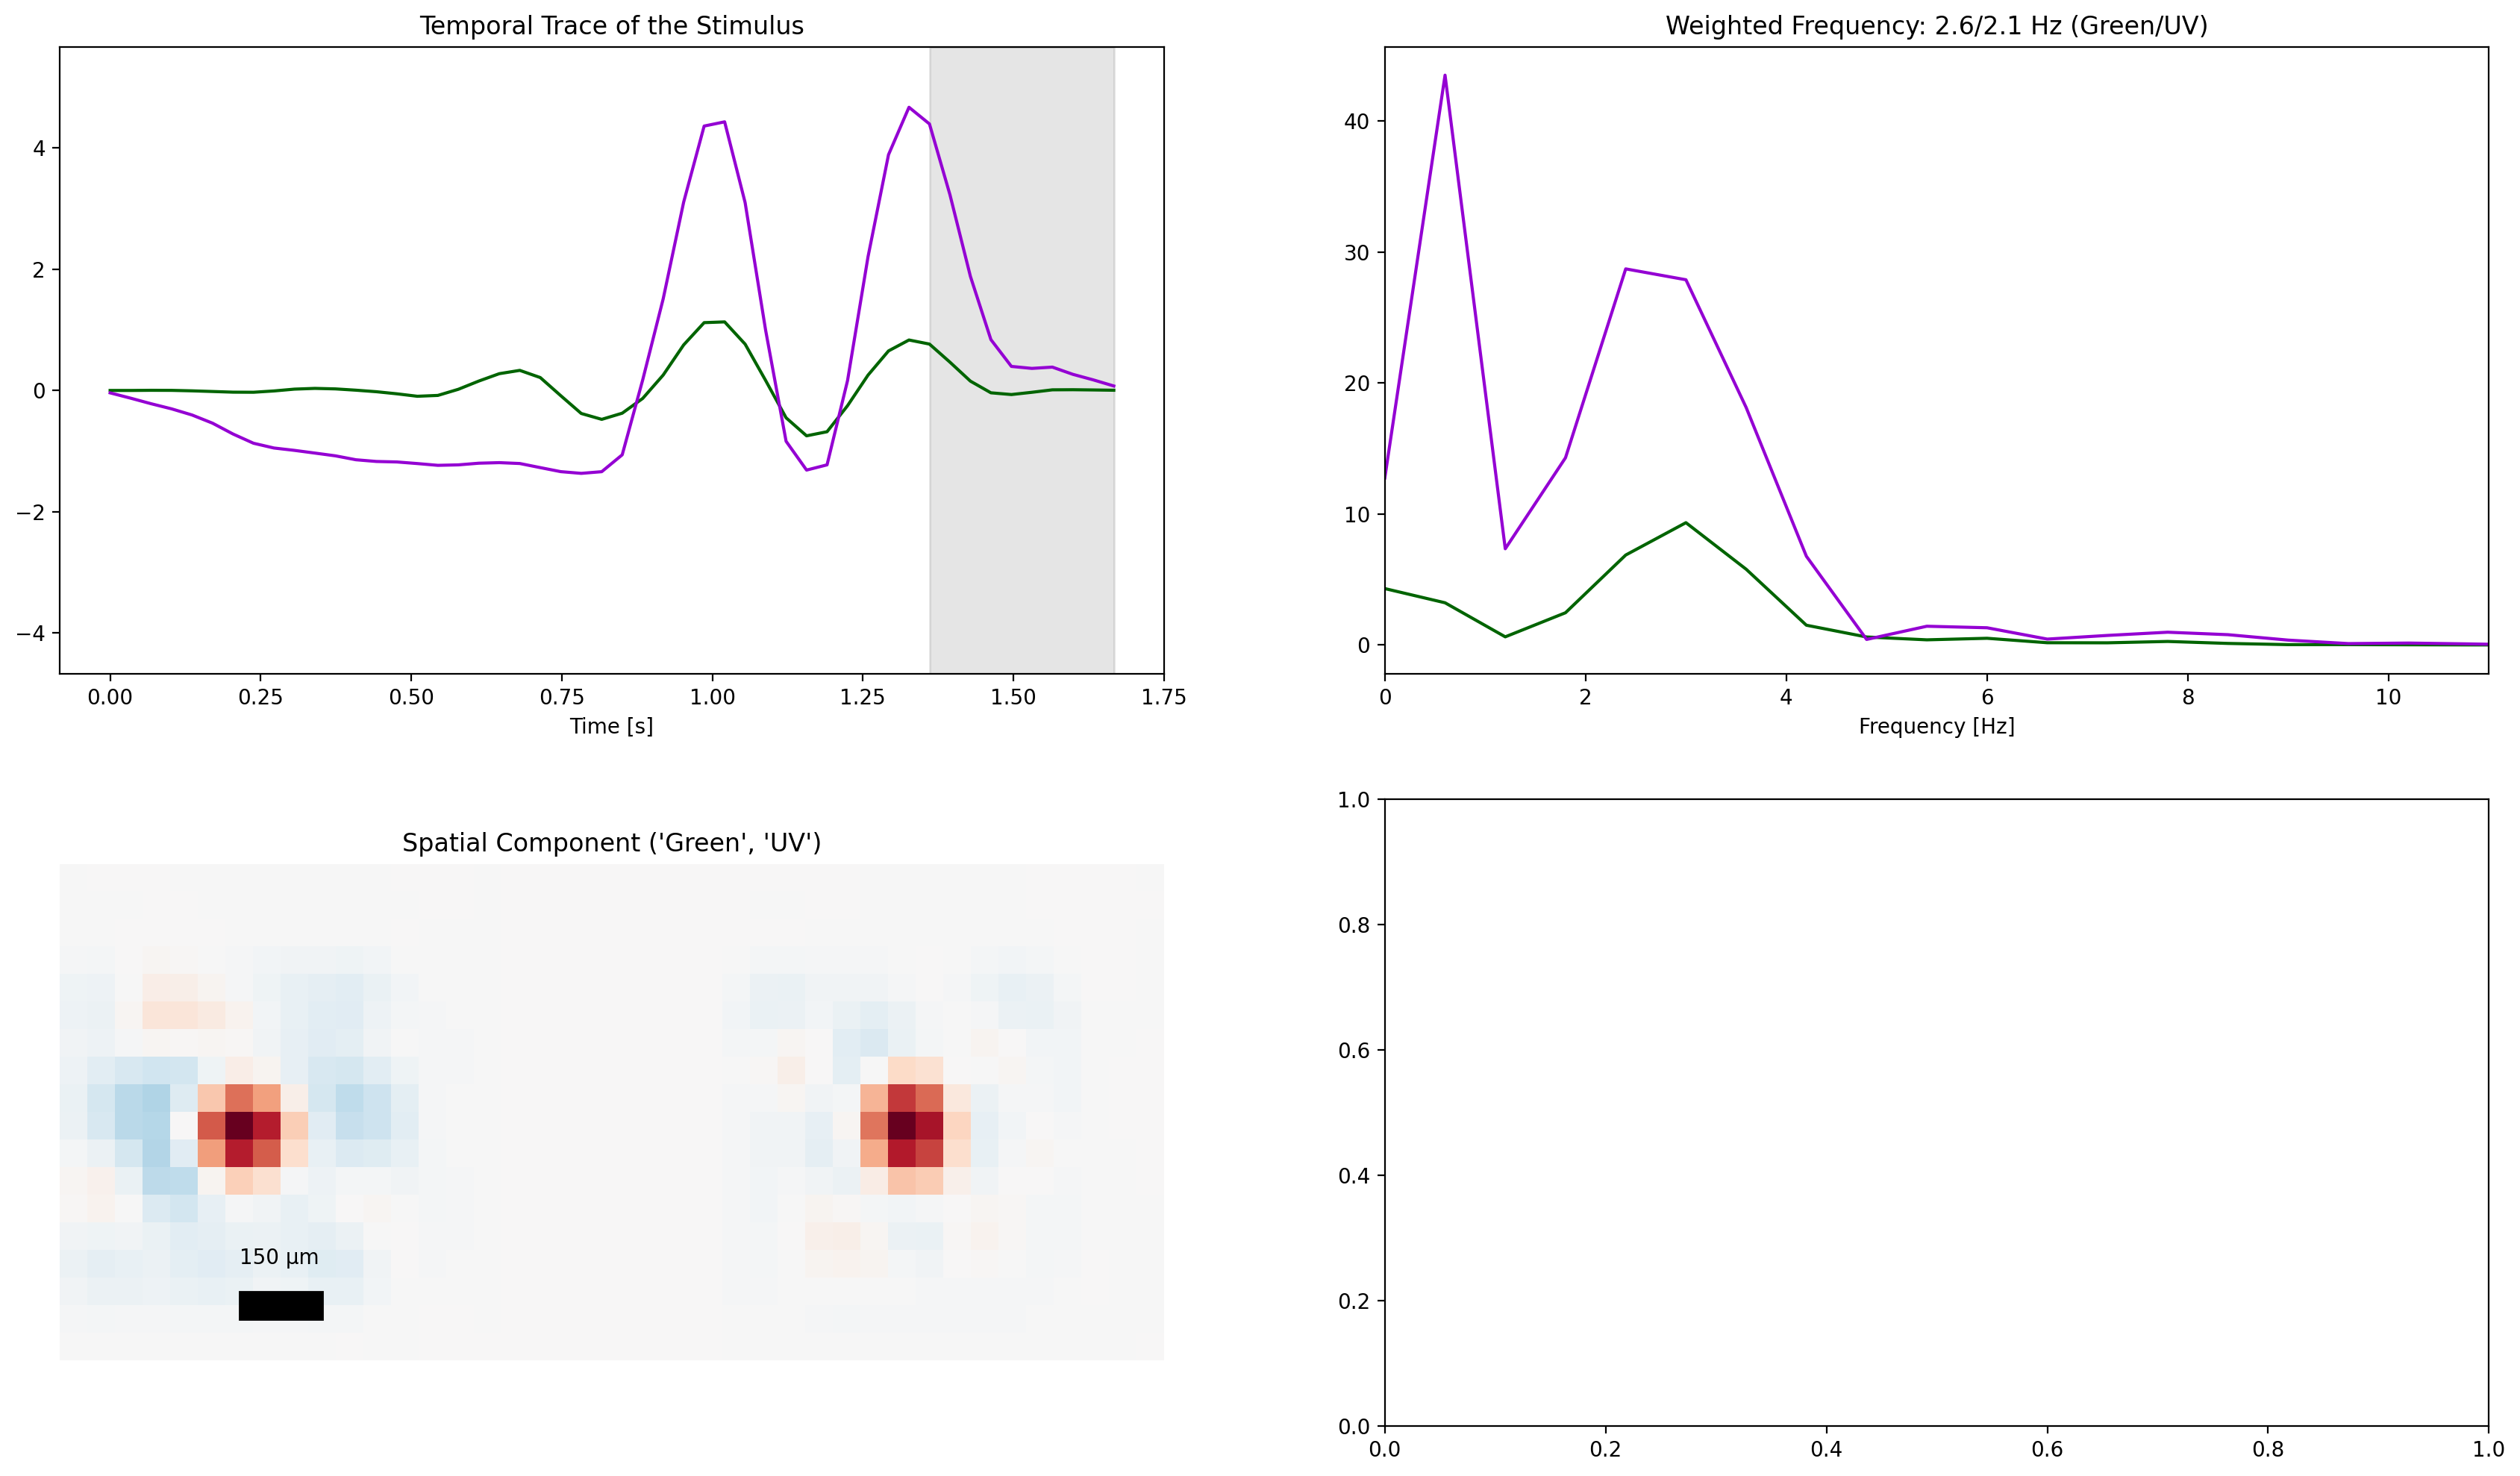

In [9]:
# Plotting probably has to be changed

from openretina.plotting import plot_stimulus_composition

stimulus_np = stimulus[0].cpu().numpy()
fig, axes = plt.subplots(2, 2, figsize=(7 * 3, 12))
plot_stimulus_composition(
    stimulus=stimulus_np,
    temporal_trace_ax=axes[0, 0],
    freq_ax=axes[0, 1],
    spatial_ax=axes[1, 0],
    highlight_x_list=[(40, 49)],
)
